#  Product Popularity Prediction using Logistic Regression

This notebook predicts whether a product is **Popular** or **Not Popular** based on the Online Retail dataset.

We will:
1. Clean and preprocess the raw retail transaction data.
2. Aggregate sales data at the **product level**.
3. Create a popularity label using the **median quantity sold** as threshold.
4. Train a **Logistic Regression model**.
5. Evaluate the model and visualize results.
6. Build a function to predict popularity for any product description.


In [37]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


## Load Dataset

We use the **Online Retail dataset** from the UCI Machine Learning Repository.  
The dataset contains transactions between Dec 2010 – Dec 2011 for a UK-based online retailer.


In [38]:
# Step 2: Load dataset
# Download from https://archive.ics.uci.edu/dataset/352/online+retail
df = pd.read_csv(r"D:\Desktop\Sem_3\Python\Online Retail.csv")

print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Data Cleaning

We perform the following:
- Remove missing values.
- Remove cancelled orders (InvoiceNo starting with "C").
- Remove rows with negative or zero `Quantity` or `UnitPrice`.

This ensures our dataset only contains valid purchases.


In [39]:
# Step 3: Data Cleaning
# Remove missing values
df = df.dropna()

# Remove cancellations (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative/zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print("Remaining rows:", df.shape)


Remaining rows: (397884, 8)


## Feature Engineering & Labeling

We aggregate transactions **at the product level** using `StockCode` and `Description`.

For each product, we calculate:
- `Total_Quantity`: total units sold
- `Num_Transactions`: number of unique invoices
- `Avg_UnitPrice`: average selling price
- `Num_Customers`: number of unique customers
- `Revenue = Total_Quantity × Avg_UnitPrice`

### Popularity Label
We define **Popular** products as those with `Total_Quantity` above the median across all products.  
This gives us a labeled dataset with `Popular = 1` (popular) or `0` (not popular).


## Feature Selection & Train/Test Split

We select numerical features to train our model:
- `Total_Quantity`
- `Num_Transactions`
- `Num_Customers`
- `Revenue`
- (optionally `Avg_UnitPrice`)

We then split the dataset into **70% training** and **30% testing**.


In [40]:
# Step 4: Feature Engineering (Aggregate at product level with Description)
product_df = df.groupby(['StockCode', 'Description']).agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique'
}).reset_index()

product_df.rename(columns={
    'Quantity': 'Total_Quantity',
    'InvoiceNo': 'Num_Transactions',
    'UnitPrice': 'Avg_UnitPrice',
    'CustomerID': 'Num_Customers'
}, inplace=True)

# Add Revenue
product_df['Revenue'] = product_df['Total_Quantity'] * product_df['Avg_UnitPrice']

# Calculate popularity threshold (median)
median_quantity = product_df['Total_Quantity'].median()

# Add Popularity label (1 = popular, 0 = not popular)
product_df['Popular'] = (product_df['Total_Quantity'] > median_quantity).astype(int)

# Save labeled dataset
product_df.to_csv("aggregated_products.csv", index=False)
print("Labeled dataset saved as 'aggregated_products.csv' with", product_df.shape[0], "products")


Labeled dataset saved as 'aggregated_products.csv' with 3897 products


In [41]:
product_df.head()

,StockCode,Description,Total_Quantity,Num_Transactions,Avg_UnitPrice,Num_Customers,Revenue,Popular
0,10002,INFLATABLE POLITICAL GLOBE,823,49,0.850000,40,699.550000,1
1,10080,GROOVY CACTUS INFLATABLE,291,21,0.411905,19,119.864286,0
2,10120,DOGGY RUBBER,193,29,0.210000,25,40.530000,0
3,10123C,HEARTS WRAPPING TAPE,5,3,0.650000,3,3.250000,0
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,5,0.420000,5,6.720000,0


#### Median is calculated based on Quantity 

In [42]:
median_quantity = product_df['Total_Quantity'].median()
print("Median quantity sold:", median_quantity)


Median quantity sold: 340.0


In [43]:
# Step 5: Feature Selection
X = product_df[['Total_Quantity', 'Num_Transactions', 'Num_Customers', 'Revenue']]
y = product_df['Popular']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (2727, 4)
Test size: (1170, 4)


## Logistic Regression Model

We train a **Logistic Regression classifier** to predict whether a product is popular.  
This model outputs a probability between 0 and 1, which we interpret as **confidence**.


In [45]:
# Step 7: Logistic Regression Model
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

## Model Evaluation

We evaluate our model using:
- Accuracy
- Precision
- Recall
- F1-Score

We also visualize the **confusion matrix** to see how well the model distinguishes popular vs not popular products.


Accuracy: 0.9367521367521368
Precision: 0.9704797047970479
Recall: 0.9006849315068494
F1 Score: 0.9342806394316163

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       586
           1       0.97      0.90      0.93       584

    accuracy                           0.94      1170
   macro avg       0.94      0.94      0.94      1170
weighted avg       0.94      0.94      0.94      1170



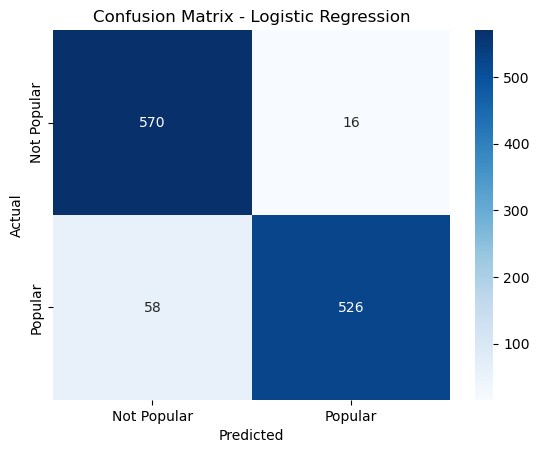

In [46]:
# Step 8: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular','Popular'], yticklabels=['Not Popular','Popular'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##  Feature Importance

We examine the coefficients of Logistic Regression to understand which features contribute most to popularity.

-  coefficient → increases chance of being **Popular**



C:\Users\HP\AppData\Local\Temp\ipykernel_4560\2445314158.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Coefficient', y='Feature', palette='viridis')


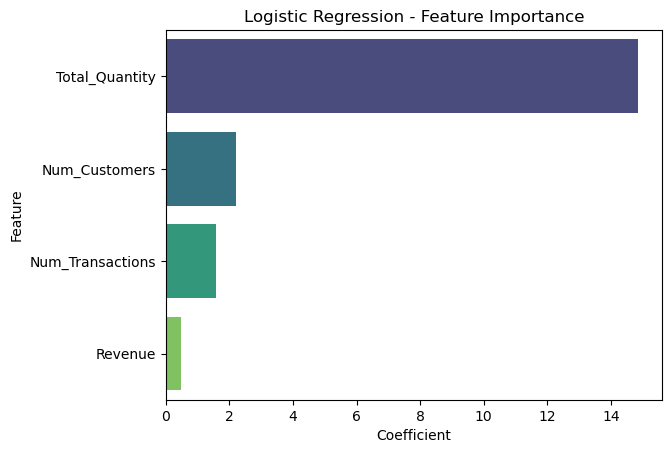

In [47]:
# Step 9: Feature Importance (Coefficients)
importance = pd.DataFrame({
    'Feature': ['Total_Quantity', 'Num_Transactions', 'Num_Customers', 'Revenue'],
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

sns.barplot(data=importance, x='Coefficient', y='Feature', palette='viridis')
plt.title("Logistic Regression - Feature Importance")
plt.show()

##  Predict Popularity for a Given Product

We build a helper function `product_to_predict(description)`:

- Input: A product description (typed manually)
- Output: Whether the product is **Popular** or **Not Popular**, along with the model’s confidence.

This makes the system interactive, allowing us to query product popularity in real time.


In [48]:
# Step 10: Function to predict popularity of a product by Description
def product_to_predict(description, product_df, model, scaler):
    # Search product by description (case-insensitive match)
    row = product_df[product_df['Description'].str.lower() == description.lower()]
    
    if row.empty:
        print(f" Product '{description}' not found in dataset.")
        return None
    
    # Extract feature values
    X_new = row[['Total_Quantity', 'Num_Transactions', 'Num_Customers', 'Revenue']]
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Predict with trained model
    pred = model.predict(X_new_scaled)[0]
    proba = model.predict_proba(X_new_scaled)[0][pred]
    
    # Map prediction
    label = "Popular " if pred == 1 else "Not Popular "
    
    print(f" Product: {row['Description'].values[0]}")
    print(f" StockCode: {row['StockCode'].values[0]}")
    print(f" Prediction: {label} (Confidence: {proba:.2f})")
    
    return pred
Des = input("Enter the description of the product: ")
product_to_predict(Des, product_df, log_reg, scaler)


 Product: DOGGY RUBBER
 StockCode: 10120
 Prediction: Not Popular  (Confidence: 0.86)


0